In [1]:
from IPython.display import clear_output

In [2]:
import os

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [3]:
curr_path = os.path.abspath(os.getcwd())

In [4]:
def get_transfer_learning_model(classifier_dropout, image_net):
    model = models.resnet152(weights=image_net)

    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(classifier_dropout, inplace=True),
        nn.Linear(model.fc.in_features, 2),
    )

    # for layer in model.classifier:
    #     if isinstance(layer, nn.Dropout):
    #         layer.p = classifier_dropout
    
    return model

In [5]:
model = get_transfer_learning_model(0.5, "IMAGENET1K_V1")

In [6]:
import torch.utils
from torch.utils.data import DataLoader, Dataset

class AugmentedDataset(Dataset):
    def __init__(self, dataset, n_batch_size, transform=None):
        self.dataset = dataset
        self.n_batch_size = n_batch_size
        self.transform = transform

    def __len__(self):
        # Return the number of batches times the batch size
        return len(self.dataset) * (self.n_batch_size // len(self.dataset))

    def __getitem__(self, idx):
        # Get the original image and label
        img, label = self.dataset[idx % len(self.dataset)]
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
target_transforms = transforms.Compose([
    lambda x:torch.tensor(x), # or just torch.tensor
    lambda x:F.one_hot(x,2),
])

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomRotation(degrees=(0, 360)),
        # transforms.RandomResizedCrop(256, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=(0.3, 1)),
        # # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        # transforms.RandomEqualize(),
        # transforms.RandomGrayscale(p=0.2),
        # transforms.CenterCrop(224),
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
        transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        transforms.RandomResizedCrop(232, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ColorJitter(hue=(-0.5,0.5)),
        transforms.RandomEqualize(),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.RandomRotation(degrees=(0, 360)),
        # transforms.RandomResizedCrop(256, scale=(0.8, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=(0.3, 1)),
        # # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        # transforms.RandomEqualize(),
        # transforms.RandomGrayscale(p=0.2),
        # transforms.CenterCrop(224),
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
        transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        transforms.RandomResizedCrop(232, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ColorJitter(hue=(-0.5,0.5)),
        transforms.RandomEqualize(),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = os.path.join(curr_path, "data")
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),target_transform=target_transforms)
                  for x in ['train', 'val']}


augmented_dataset = {
    x: AugmentedDataset(image_datasets[x], 50, transform=data_transforms[x])
    for x in ['train', 'val']
}


class_names = image_datasets['train'].classes

dataloaders = {x: DataLoader(augmented_dataset[x], batch_size=50,
                                             shuffle=True, num_workers=10)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device

(['cleaned', 'dirty'], device(type='cuda', index=0))

train


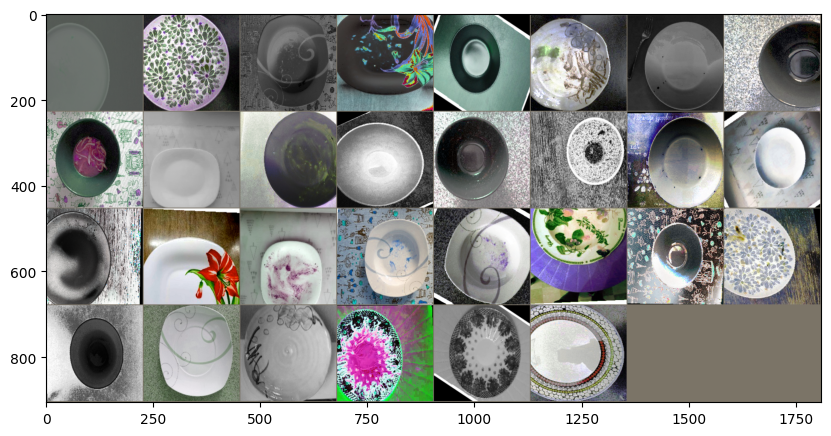

val


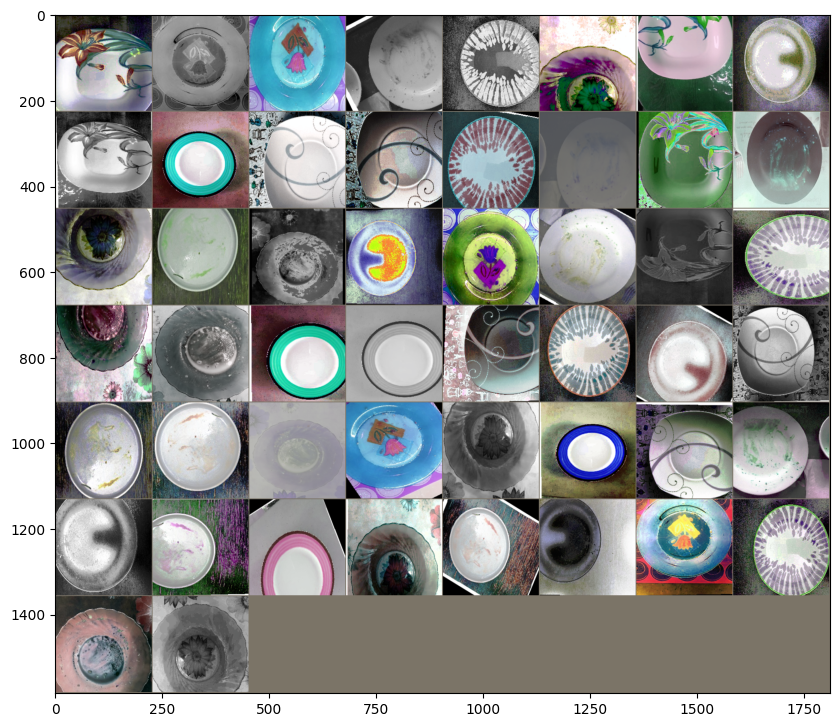

In [7]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp,)
    #if title is not None:
    #    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

phases = ['train','val']
for phase in phases:
    print(phase)
    for inputs, labels in dataloaders[phase]:

        # Get a batch of training data
        inputs, classes = next(iter(dataloaders[phase]))
        classes = classes.max(axis=1)[1]
        
        # Make a grid from batch
        out = make_grid(inputs)

        imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_func(model, optimizer, exp_lr_scheduler, clip_value):
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    running_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.float())

        total += output.size(0)
        running_loss += loss.item() * output.size(0)

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        # accuracy
        _, predicted = torch.max(output.data, 1)
        _, correct_class = torch.max(target.data, 1)
        
        correct += (predicted == correct_class).sum().item()
    
    exp_lr_scheduler.step()
    
    return {
        "mean_loss": running_loss / total,
        "mean_accuracy": correct / total,
    }

def test_func(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloaders['val']):
            
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, correct_class = torch.max(target.data, 1)
            total += target.size(0)
            correct += (predicted == correct_class).sum().item()

            # loss
            running_loss += F.cross_entropy(outputs, target.float()).item() * outputs.size(0)
    
    return {
        "mean_loss": running_loss / total,
        "mean_accuracy": correct / total,
    }

In [9]:
import os
import tempfile

from ray.train import Checkpoint

def train_dishs(config, max_epochs=30, tunning=True):
    
    # Data Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_transfer_learning_model(config['classifier_dropout'], config['image_net'])
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config['weight_decay'])
    
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=config['lr_scheduler_gamma'])
    for i in range(max_epochs):
        train_log = train_func(model, optimizer, exp_lr_scheduler, config['clip_value'])
        val_log = test_func(model)

        if tunning:
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint = None
                if (i + 1) % max_epochs == 0 and (val_log["mean_loss"] < 0.4):
                    # This saves the model to the trial directory
                    torch.save(
                        model.state_dict(),
                        os.path.join(temp_checkpoint_dir, "model.pth")
                    )
                    checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

                # Send the current training result back to Tune
                train.report(
                    {
                        "train_mean_loss": train_log["mean_loss"],
                        "train_mean_accuracy": train_log["mean_accuracy"],
                        "val_mean_loss": val_log["mean_loss"],
                        "val_mean_accuracy": val_log["mean_accuracy"],
                    },
                    checkpoint=checkpoint
                )
        else:
            print("-"*10, f"epoch: {i+1}/{max_epochs}","-"*10)
            print(f"train: {train_log}\nval: {val_log}")
    if not tunning:
        return {
            "model": model,
            "log": {
                "train": train_log,
                "val": val_log,
            },
        }

In [10]:
"""config = {
    "lr":0.1,
    "momentum":0.5,
}

train_dishs(config)"""

'config = {\n    "lr":0.1,\n    "momentum":0.5,\n}\n\ntrain_dishs(config)'

In [11]:
import json

try:
    with open("best_result.json", "r") as f:
        curr_best_params = [json.load(f)]
except:
    curr_best_params = None

curr_best_params

[{'classifier_dropout': 0.27430976632907944,
  'clip_value': '5',
  'image_net': 'IMAGENET1K_V1',
  'lr': 0.051995338546820695,
  'lr_scheduler_gamma': 0.6713619607721294,
  'momentum': 0.4881548853258346,
  'weight_decay': 0.02942307050002735}]

In [12]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

space = {
    "lr": hp.loguniform("lr", -3, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    "classifier_dropout": hp.uniform("classifier_dropout", 0.1, 0.95),
    "weight_decay": hp.loguniform("weight_decay", -6, -2),
    "clip_value": hp.randint("clip_value", 1, 5+1),
    "lr_scheduler_gamma": hp.uniform("lr_scheduler_gamma", 0.5, 1.0),
    "image_net": hp.choice("image_net", ["IMAGENET1K_V1", "IMAGENET1K_V2"]),
}

metric = "val_mean_accuracy"
mode = "max"

hyperopt_search = HyperOptSearch(
    space,
    metric=metric,
    mode=mode,
    points_to_evaluate = curr_best_params
)

asas_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric=metric,
    mode=mode,
    max_t=10,
    grace_period=1,
    reduction_factor=3,
    brackets=2
)

trainable_with_resources = tune.with_resources(train_dishs, {"cpu": 8, "gpu": 1})

tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        num_samples=40,
        search_alg=hyperopt_search,
        scheduler=asas_scheduler
    ),
)
results = tuner.fit()

2024-06-17 13:42:28,704	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_dishs_2024-06-17_13-33-52' in 0.0111s.
2024-06-17 13:42:28,719	INFO tune.py:1041 -- Total run time: 513.09 seconds (513.03 seconds for the tuning loop).


In [13]:
best_result = results.get_best_result("val_mean_accuracy", mode="max")
best_result.metrics

{'train_mean_loss': 0.07116140425205231,
 'train_mean_accuracy': 0.9666666666666667,
 'val_mean_loss': 0.06827197968959808,
 'val_mean_accuracy': 0.98,
 'timestamp': 1718645841,
 'checkpoint_dir_name': None,
 'done': True,
 'training_iteration': 10,
 'trial_id': 'ce003b37',
 'date': '2024-06-17_13-37-21',
 'time_this_iter_s': 1.5859277248382568,
 'time_total_s': 17.098506212234497,
 'pid': 439248,
 'hostname': 'DESKTOP-GF0BL1G',
 'node_ip': '172.18.58.174',
 'config': {'classifier_dropout': 0.3147882737109384,
  'clip_value': 2,
  'image_net': 'IMAGENET1K_V1',
  'lr': 0.16024329515574662,
  'lr_scheduler_gamma': 0.790191487707217,
  'momentum': 0.4692253923406301,
  'weight_decay': 0.010641355644880819},
 'time_since_restore': 17.098506212234497,
 'iterations_since_restore': 10,
 'experiment_tag': '15_classifier_dropout=0.3148,clip_value=2,image_net=IMAGENET1K_V1,lr=0.1602,lr_scheduler_gamma=0.7902,momentum=0.4692,weight_decay=0.0106'}

In [14]:
import json

with open("best_result.json", 'w') as f:
    json.dump(best_result.config, f, default=str)

In [15]:
# best_result = results.get_best_result("val_mean_loss", mode="min")
# with best_result.checkpoint.as_directory() as checkpoint_dir:
#     state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

# model = get_transfer_learning_model(best_result.config['classifier_dropout']).to(device)
# model.load_state_dict(state_dict)
# model.classifier
# to_csv(model)

In [16]:
from PIL import Image
import pandas as pd

def to_csv(model, batch_size=10):
    model.eval()
    PATH_TEST = os.path.join(curr_path, "data/test/")
    test_file_names = os.listdir(PATH_TEST)
    test_file_names.sort()

    submission_csv = {
        "id": [],
        "label": []
    }

    for file_name in test_file_names:
        id = file_name.split(".")[0]
        test_input = Image.open(os.path.join(PATH_TEST, file_name))
        test_input = data_transforms['test'](test_input).to(device).unsqueeze(0)
        with torch.no_grad():
            pred_test_label = model(test_input).max(1).indices.item()
            pred_test_label = class_names[pred_test_label]
        submission_csv['id'].append(id)
        submission_csv['label'].append(pred_test_label)

    submission_csv = pd.DataFrame(submission_csv).set_index("id")
    submission_csv.to_csv("submission.csv")

In [17]:
import json

with open("best_result.json", "r") as f:
    best_config_loaded = json.load(f)

best_config_loaded

{'classifier_dropout': 0.3147882737109384,
 'clip_value': '2',
 'image_net': 'IMAGENET1K_V1',
 'lr': 0.16024329515574662,
 'lr_scheduler_gamma': 0.790191487707217,
 'momentum': 0.4692253923406301,
 'weight_decay': 0.010641355644880819}

In [18]:
best_config_train_model = train_dishs(best_config_loaded, max_epochs=10, tunning=False)

---------- epoch: 1/10 ----------
train: {'mean_loss': 0.6866509914398193, 'mean_accuracy': 0.5666666666666667}
val: {'mean_loss': 0.8045222163200378, 'mean_accuracy': 0.5}
---------- epoch: 2/10 ----------
train: {'mean_loss': 0.9196197986602783, 'mean_accuracy': 0.5}
val: {'mean_loss': 3.024925470352173, 'mean_accuracy': 0.5}
---------- epoch: 3/10 ----------
train: {'mean_loss': 2.5424184799194336, 'mean_accuracy': 0.5}
val: {'mean_loss': 1.205626368522644, 'mean_accuracy': 0.5}
---------- epoch: 4/10 ----------
train: {'mean_loss': 0.8475249409675598, 'mean_accuracy': 0.5666666666666667}
val: {'mean_loss': 1.9461236000061035, 'mean_accuracy': 0.5}
---------- epoch: 5/10 ----------
train: {'mean_loss': 2.1628811359405518, 'mean_accuracy': 0.5}
val: {'mean_loss': 0.7982739210128784, 'mean_accuracy': 0.52}
---------- epoch: 6/10 ----------
train: {'mean_loss': 1.0761007070541382, 'mean_accuracy': 0.6}
val: {'mean_loss': 1.1565872430801392, 'mean_accuracy': 0.56}
---------- epoch: 7/10

In [19]:
new_model = best_config_train_model['model']

In [20]:
# phases = ['train','val']
# for phase in phases:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     for inputs, labels in dataloaders[phase]:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         #calculate val loss
#         outputs = new_model(inputs)
#         loss = F.cross_entropy(outputs, labels.float()).item()
#         print(loss)

#         # Get a batch of training data
#         classes = labels.max(axis=1)[1]
#         pred_classes = outputs.max(axis=1)[1]
#         print([class_names[i] for i in classes])
#         print(pred_classes == classes)
        
#         # Make a grid from batch
#         out = make_grid(inputs)

#         imshow(out.cpu(), title=[class_names[x] for x in classes])

In [21]:
to_csv(new_model)

In [22]:
df = results.get_dataframe()
df.head()

,train_mean_loss,train_mean_accuracy,val_mean_loss,val_mean_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,config/classifier_dropout,config/clip_value,config/image_net,config/lr,config/lr_scheduler_gamma,config/momentum,config/weight_decay,logdir
0,0.220084,0.933333,0.350013,0.90,1718645655,None,True,10,a2053816,2024-06-17_13-34-15,...,17.857184,10,0.274310,5,IMAGENET1K_V1,0.051995,0.671362,0.488155,0.029423,a2053816
1,0.252066,0.900000,0.955620,0.82,1718645676,None,True,10,eef7fd31,2024-06-17_13-34-36,...,17.732920,10,0.664696,5,IMAGENET1K_V1,0.100111,0.752280,0.893946,0.010152,eef7fd31
2,0.855804,0.566667,0.853476,0.48,1718645685,None,True,3,a9dd5681,2024-06-17_13-34-45,...,6.477271,3,0.681428,3,IMAGENET1K_V1,0.119110,0.548990,0.643766,0.034722,a9dd5681
3,8.694726,0.500000,4.308455,0.50,1718645694,None,True,3,bdbaf060,2024-06-17_13-34-54,...,6.673824,3,0.432690,3,IMAGENET1K_V1,0.297117,0.704064,0.352116,0.003064,bdbaf060
4,0.521338,0.900000,0.622582,0.60,1718645713,None,True,9,d7e1a287,2024-06-17_13-35-13,...,17.164404,9,0.126346,1,IMAGENET1K_V2,0.093949,0.714906,0.353102,0.067871,d7e1a287


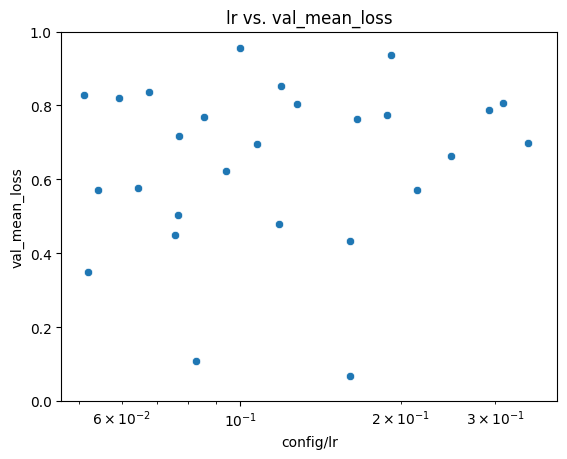

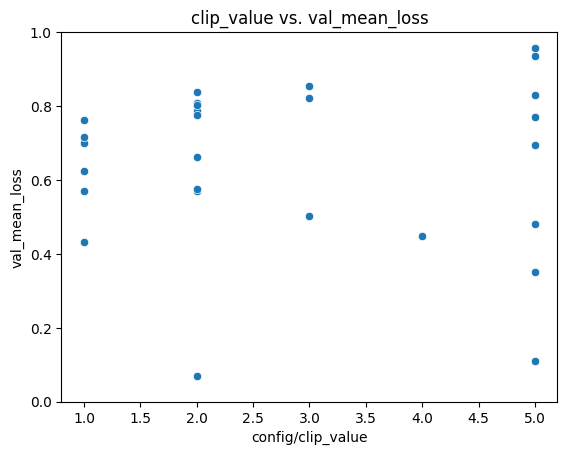

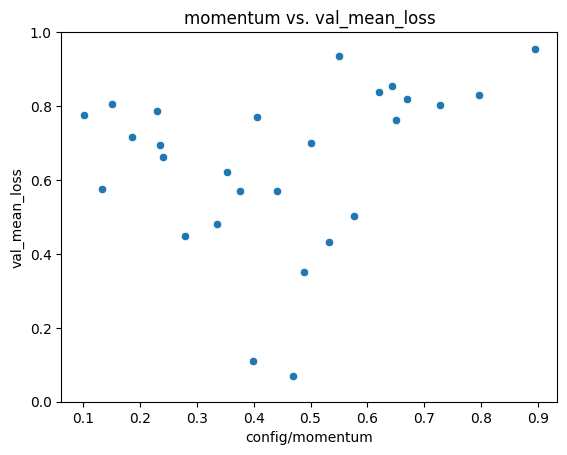

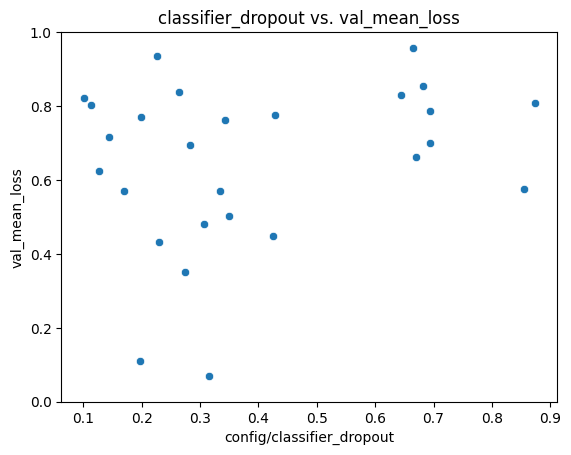

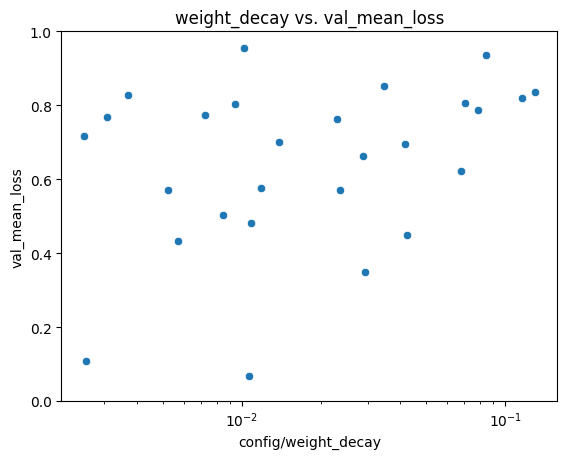

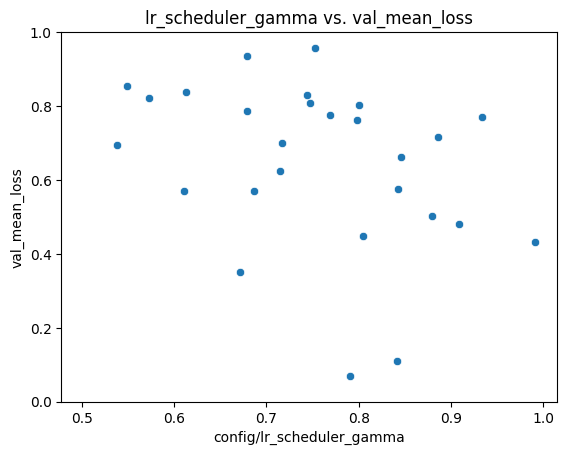

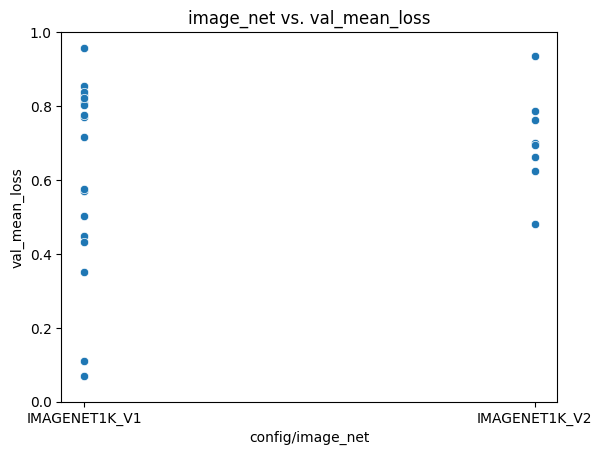

In [23]:
# Analyze the results
import seaborn as sns
import matplotlib.pyplot as plt

log_plots = ["lr", "weight_decay"]
def plot_scatter(data, x_param, y_param="val_mean_loss"):
    
    if x_param == "clip_value":
        data[f"config/{x_param}"] = np.array(data[f"config/{x_param}"], dtype=int)
    sns.scatterplot(data=data, x=f'config/{x_param}', y=y_param)
    plt.title(f'{x_param} vs. {y_param}')
    plt.ylim(0,1.0)
    #plt.yscale("log")
    if x_param in log_plots:
        plt.xscale("log")
    plt.show()

# Create scatter plots for each hyperparameter
plot_scatter(df, 'lr')
plot_scatter(df, 'clip_value')
plot_scatter(df, 'momentum')
plot_scatter(df, 'classifier_dropout')
plot_scatter(df, 'weight_decay')
plot_scatter(df, 'lr_scheduler_gamma')
plot_scatter(df, 'image_net')